IMPORT

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")
from utils import *
from linear_regression import *
from svm import *
from softmax import *
from features import *
from kernel import *


UTILS

In [9]:
import pickle, gzip, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math


def plot_images(X):
    if X.ndim == 1:
        X = np.array([X])
    num_images = X.shape[0]
    num_rows = math.floor(math.sqrt(num_images))
    num_cols = math.ceil(num_images/num_rows)
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()


def pick_examples_of(X, Y, labels, total_count):
    bool_arr = None
    for label in labels:
        bool_arr_for_label = (Y == label)
        if bool_arr is None:
            bool_arr = bool_arr_for_label
        else:
            bool_arr |= bool_arr_for_label
    filtered_x = X[bool_arr]
    filtered_y = Y[bool_arr]
    return (filtered_x[:total_count], filtered_y[:total_count])


def extract_training_and_test_examples_with_labels(train_x, train_y, test_x, test_y, labels, training_count, test_count):
    filtered_train_x, filtered_train_y = pick_examples_of(train_x, train_y, labels, training_count)
    filtered_test_x, filtered_test_y = pick_examples_of(test_x, test_y, labels, test_count)
    return (filtered_train_x, filtered_train_y, filtered_test_x, filtered_test_y)

def write_pickle_data(data, file_name):
    f = gzip.open(file_name, 'wb')
    pickle.dump(data, f)
    f.close()

def read_pickle_data(file_name):
    f = gzip.open(file_name, 'rb')
    data = pickle.load(f, encoding='latin1')
    f.close()
    return data

def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('../Datasets/mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

def load_train_and_test_pickle(file_name):
    train_x, train_y, test_x, test_y = read_pickle_data(file_name)
    return train_x, train_y, test_x, test_y

# returns the feature set in a numpy ndarray
def load_CSV(filename):
    stuff = np.asarray(np.loadtxt(open(filename, 'rb'), delimiter=','))
    return stuff



LINEAR REGRESSION CLOSED FORM SOLUTION

In [50]:
import numpy as np

### Functions for you to fill in ###

def closed_form(X, Y, lambda_factor):
    """
    Computes the closed form solution of linear regression with L2 regularization

    Args:
        X - (n, d + 1) NumPy array (n datapoints each with d features plus the bias feature in the first dimension)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
    Returns:
        theta - (d + 1, ) NumPy array containing the weights of linear regression. Note that theta[0]
        represents the y-axis intercept of the model and therefore X[0] = 1
    """
    # YOUR CODE HERE
    
    theta = np.dot(np.linalg.inv(np.dot(np.transpose(X), X) + lambda_factor * np.identity(X.shape[1])), np.dot(np.transpose(X), Y))
    
    return theta
    raise NotImplementedError

### Functions which are already complete, for you to use ###

def compute_test_error_linear(test_x, Y, theta):
    test_y_predict = np.round(np.dot(test_x, theta))
    test_y_predict[test_y_predict < 0] = 0
    test_y_predict[test_y_predict > 9] = 9
    return 1 - np.mean(test_y_predict == Y)


SVM

In [85]:
import numpy as np
from sklearn.svm import LinearSVC


### Functions for you to fill in ###

def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classifciation

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    
    model = LinearSVC(C= 0.1, random_state= 0)
    
    model.fit(train_x, train_y)

    pred_test_y = model.predict(test_x)
    return pred_test_y
    raise NotImplementedError


def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """

    model = LinearSVC(random_state= 0)

    model.fit(train_x,train_y)

    pred_test_y = model.predict(test_x)
    return pred_test_y
    raise NotImplementedError


def compute_test_error_svm(test_y, pred_test_y):
    return 1 - np.mean(pred_test_y == test_y)



SOFTMAX

In [ ]:
import sys
sys.path.append("..")
import utils
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse


def augment_feature_vector(X):
    """
    Adds the x[i][0] = 1 feature for each data point x[i].

    Args:
        X - a NumPy matrix of n data points, each with d - 1 features

    Returns: X_augment, an (n, d) NumPy array with the added feature for each datapoint
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

def compute_probabilities(X, theta, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    #YOUR CODE HERE

    Z = np.dot(theta, X.T) / temp_parameter  

    C = np.max(Z, axis=0)  
    Z_stable = Z - C  
    exp_Z = np.exp(Z_stable)

    H = exp_Z / np.sum(exp_Z, axis=0)

    return H

    raise NotImplementedError

def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    #YOUR CODE HERE

    Z = np.dot(theta, X.T) / temp_parameter  
    ceta = np.max(Z, axis=0)  
    Z_stable = Z - ceta  
    exp_Z = np.exp(Z_stable)

    log_prob = np.log(exp_Z/np.sum(exp_Z,axis=0))


    log_proba = log_prob[Y,np.arange(X.shape[0])] 

    C = -np.sum(log_proba)/X.shape[0] + (lambda_factor/2) * np.sum(theta**2)
    
    

    return C
    raise NotImplementedError

def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    #YOUR CODE HERE

    n, d = X.shape  # Número de amostras (n) e características (d)
    k = theta.shape[0]  # Número de classes

    # Computamos os scores normalizados
    Z = np.dot(theta, X.T) / temp_parameter  
    C = np.max(Z, axis=0)  # Estabilidade numérica
    Z_stable = Z - C  # Normaliza antes da exponencial

    # Calculamos a softmax
    exp_Z = np.exp(Z_stable)
    probabilities = exp_Z / np.sum(exp_Z, axis=0)  # (k, n)

    # Criamos uma matriz one-hot para os rótulos verdadeiros usando scipy.sparse
    Y_one_hot = sparse.coo_matrix(([1] * n, (Y, np.arange(n))), shape=(k, n)).toarray()

    # Computamos o gradiente da função de custo
    gradient = (-1 / (temp_parameter * n)) * np.dot((Y_one_hot - probabilities), X)
    gradient += lambda_factor * theta  # Termo de regularização

    # Atualizamos os parâmetros theta
    theta -= alpha * gradient

    return theta 

def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    #YOUR CODE HERE
    raise NotImplementedError

def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    #YOUR CODE HERE
    raise NotImplementedError

def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

def get_classification(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

def plot_cost_function_over_time(cost_function_history):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.show()

def compute_test_error(X, Y, theta, temp_parameter):
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)


TEST

In [129]:
import os
import sys
import time
import traceback
import numpy as np
import linear_regression
import svm
import softmax
import features
import kernel

sys.path.append("..")
import utils

verbose = False

epsilon = 1e-6

def green(s):
    return '\033[1;32m%s\033[m' % s

def yellow(s):
    return '\033[1;33m%s\033[m' % s

def red(s):
    return '\033[1;31m%s\033[m' % s

def log(*m):
    print(" ".join(map(str, m)))

def log_exit(*m):
    log(red("ERROR:"), *m)
    exit(1)


def check_real(ex_name, f, exp_res, *args):
    try:
        res = f(*args)
    except NotImplementedError:
        log(red("FAIL"), ex_name, ": not implemented")
        return True
    if not np.isreal(res):
        log(red("FAIL"), ex_name, ": does not return a real number, type: ", type(res))
        return True
    if not -epsilon < res - exp_res < epsilon:
        log(red("FAIL"), ex_name, ": incorrect answer. Expected", exp_res, ", got: ", res)
        return True


def equals(x, y):
    if type(y) == np.ndarray:
        return (np.abs(x - y) < epsilon).all()
    return -epsilon < x - y < epsilon

def check_tuple(ex_name, f, exp_res, *args, **kwargs):
    try:
        res = f(*args, **kwargs)
    except NotImplementedError:
        log(red("FAIL"), ex_name, ": not implemented")
        return True
    if not type(res) == tuple:
        log(red("FAIL"), ex_name, ": does not return a tuple, type: ", type(res))
        return True
    if not len(res) == len(exp_res):
        log(red("FAIL"), ex_name, ": expected a tuple of size ", len(exp_res), " but got tuple of size", len(res))
        return True
    if not all(equals(x, y) for x, y in zip(res, exp_res)):
        log(red("FAIL"), ex_name, ": incorrect answer. Expected", exp_res, ", got: ", res)
        return True

def check_array(ex_name, f, exp_res, *args):
    try:
        res = f(*args)
    except NotImplementedError:
        log(red("FAIL"), ex_name, ": not implemented")
        return True
    if not type(res) == np.ndarray:
        log(red("FAIL"), ex_name, ": does not return a numpy array, type: ", type(res))
        return True
    if not len(res) == len(exp_res):
        log(red("FAIL"), ex_name, ": expected an array of shape ", exp_res.shape, " but got array of shape", res.shape)
        return True
    if not equals(res, exp_res):
        log(red("FAIL"), ex_name, ": incorrect answer. Expected", exp_res, ", got: ", res)

        return True

def check_list(ex_name, f, exp_res, *args):
    try:
        res = f(*args)
    except NotImplementedError:
        log(red("FAIL"), ex_name, ": not implemented")
        return True
    if not type(res) == list:
        log(red("FAIL"), ex_name, ": does not return a list, type: ", type(res))
        return True
    if not len(res) == len(exp_res):
        log(red("FAIL"), ex_name, ": expected a list of size ", len(exp_res), " but got list of size", len(res))
        return True
    if not all(equals(x, y) for x, y in zip(res, exp_res)):
        log(red("FAIL"), ex_name, ": incorrect answer. Expected", exp_res, ", got: ", res)
        return True

def check_get_mnist():
    ex_name = "Get MNIST data"
    train_x, train_y, test_x, test_y = get_MNIST_data()
    log(green("PASS"), ex_name, "")


def check_closed_form():
    ex_name = "Closed form"
    X = np.arange(1, 16).reshape(3, 5)
    Y = np.arange(1, 4)
    lambda_factor = 0.5
    exp_res = np.array([-0.03411225,  0.00320187,  0.04051599,  0.07783012,  0.11514424])
    if check_array(
            ex_name, closed_form,
            exp_res, X, Y, lambda_factor):
        return

    log(green("PASS"), ex_name, "")

def check_svm():
    ex_name = "One vs rest SVM"
    n, m, d = 5, 3, 7
    train_x = np.random.random((n, d))
    test_x = train_x[:m]
    train_y = np.zeros(n)
    train_y[-1] = 1
    exp_res = np.zeros(m)

    if check_array(
            ex_name, one_vs_rest_svm,
            exp_res, train_x, train_y, test_x):
        return

    train_y = np.ones(n)
    train_y[-1] = 0
    exp_res = np.ones(m)

    if check_array(
            ex_name, one_vs_rest_svm,
            exp_res, train_x, train_y, test_x):
        return

    log(green("PASS"), ex_name, "")


def check_compute_probabilities():
    ex_name = "Compute probabilities"
    n, d, k = 3, 5, 7
    X = np.arange(0, n * d).reshape(n, d)
    zeros = np.zeros((k, d))
    temp = 0.2
    exp_res = np.ones((k, n)) / k
    if check_array(
            ex_name, compute_probabilities,
            exp_res, X, zeros, temp):
        return

    theta = np.arange(0, k * d).reshape(k, d)
    compute_probabilities(X, theta, temp)
    exp_res = np.zeros((k, n))
    exp_res[-1] = 1
    if check_array(
            ex_name, compute_probabilities,
            exp_res, X, theta, temp):
        return

    log(green("PASS"), ex_name, "")

def check_compute_cost_function():
    ex_name = "Compute cost function"
    n, d, k = 3, 5, 7
    X = np.arange(0, n * d).reshape(n, d)
    Y = np.arange(0, n)
    zeros = np.zeros((k, d))
    temp = 0.2
    lambda_factor = 0.5
    exp_res = 1.9459101490553135
    if check_real(
            ex_name, compute_cost_function,
            exp_res, X, Y, zeros, lambda_factor, temp):
        return
    log(green("PASS"), ex_name, "")

def check_run_gradient_descent_iteration():
    ex_name = "Run gradient descent iteration"
    n, d, k = 3, 5, 7
    X = np.arange(0, n * d).reshape(n, d)
    Y = np.arange(0, n)
    zeros = np.zeros((k, d))
    alpha = 2
    temp = 0.2
    lambda_factor = 0.5
    exp_res = np.zeros((k, d))
    exp_res = np.array([
       [ -7.14285714,  -5.23809524,  -3.33333333,  -1.42857143, 0.47619048],
       [  9.52380952,  11.42857143,  13.33333333,  15.23809524, 17.14285714],
       [ 26.19047619,  28.0952381 ,  30.        ,  31.9047619 , 33.80952381],
       [ -7.14285714,  -8.57142857, -10.        , -11.42857143, -12.85714286],
       [ -7.14285714,  -8.57142857, -10.        , -11.42857143, -12.85714286],
       [ -7.14285714,  -8.57142857, -10.        , -11.42857143, -12.85714286],
       [ -7.14285714,  -8.57142857, -10.        , -11.42857143, -12.85714286]
    ])

    if check_array(
            ex_name, run_gradient_descent_iteration,
            exp_res, X, Y, zeros, alpha, lambda_factor, temp):
        return
    run_gradient_descent_iteration(X, Y, zeros, alpha, lambda_factor, temp)
    log(green("PASS"), ex_name, "")

def check_update_y():
    ex_name = "Update y"
    train_y = np.arange(0, 10)
    test_y = np.arange(9, -1, -1)
    exp_res = (
            np.array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0]),
            np.array([0, 2, 1, 0, 2, 1, 0, 2, 1, 0])
            )
    if check_tuple(
            ex_name, update_y,
            exp_res, train_y, test_y):
        return
    log(green("PASS"), ex_name, "")

###Correction note:  check_project_onto_PC fucntion have been modified since release.
def check_project_onto_PC():
    ex_name = "Project onto PC"
    X = np.array([
        [1, 2, 3],
        [2, 4, 6],
        [3, 6, 9],
        [4, 8, 12],
    ]);
    x_centered, feature_means = features.center_data(X)
    pcs = features.principal_components(x_centered)
    exp_res = np.array([
        [-5.61248608, 0],
        [-1.87082869, 0],
        [1.87082869, 0],
        [5.61248608, 0],
    ])
    n_components = 2
    if check_array(
            ex_name, features.project_onto_PC,
            exp_res, X, pcs, n_components, feature_means):
        return
    log(green("PASS"), ex_name, "")

def check_polynomial_kernel():
    ex_name = "Polynomial kernel"
    n, m, d = 3, 5, 7
    c = 1
    p = 2
    X = np.random.random((n, d))
    Y = np.random.random((m, d))
    try:
        K = kernel.polynomial_kernel(X, Y, c, d)
    except NotImplementedError:
        log(red("FAIL"), ex_name, ": not implemented")
        return True
    for i in range(n):
        for j in range(m):
            exp = (X[i] @ Y[j] + c) ** d
            got = K[i][j]
            if (not equals(exp, got)):
                log(
                    red("FAIL"), ex_name,
                    ": values at ({}, {}) do not match. Expected {}, got {}"
                    .format(i, j, exp, got)
                )
    log(green("PASS"), ex_name, "")

def check_rbf_kernel():
    ex_name = "RBF kernel"
    n, m, d = 3, 5, 7
    gamma = 0.5
    X = np.random.random((n, d))
    Y = np.random.random((m, d))
    try:
        K = kernel.rbf_kernel(X, Y, gamma)
    except NotImplementedError:
        log(red("FAIL"), ex_name, ": not implemented")
        return True
    for i in range(n):
        for j in range(m):
            exp = np.exp(-gamma * (np.linalg.norm(X[i] - Y[j]) ** 2))
            got = K[i][j]
            if (not equals(exp, got)):
                log(
                    red("FAIL"), ex_name,
                    ": values at ({}, {}) do not match. Expected {}, got {}"
                    .format(i, j, exp, got)
                )
    log(green("PASS"), ex_name, "")


def main():
    log(green("PASS"), "Import mnist project")
    try:
        check_get_mnist()
        check_closed_form()
        check_svm()
        check_compute_probabilities()
        check_compute_cost_function()
        check_run_gradient_descent_iteration()
        check_update_y()
        check_project_onto_PC()
        check_polynomial_kernel()
        check_rbf_kernel()
    except Exception:
        log_exit(traceback.format_exc())

if __name__ == "__main__":
    main()


PASS Import mnist project
PASS Get MNIST data 
PASS Closed form 
PASS One vs rest SVM 
PASS Compute probabilities 
PASS Compute cost function 
ERROR: Traceback (most recent call last):
  File "C:\Users\kevin\AppData\Local\Temp\ipykernel_16344\1648585844.py", line 308, in main
    check_run_gradient_descent_iteration()
  File "C:\Users\kevin\AppData\Local\Temp\ipykernel_16344\1648585844.py", line 207, in check_run_gradient_descent_iteration
    if check_array(
       ^^^^^^^^^^^^
  File "C:\Users\kevin\AppData\Local\Temp\ipykernel_16344\1648585844.py", line 73, in check_array
    res = f(*args)
          ^^^^^^^^
  File "C:\Users\kevin\AppData\Local\Temp\ipykernel_16344\1921919700.py", line 122, in run_gradient_descent_iteration
    raise theta_a
TypeError: exceptions must derive from BaseException



MAIN

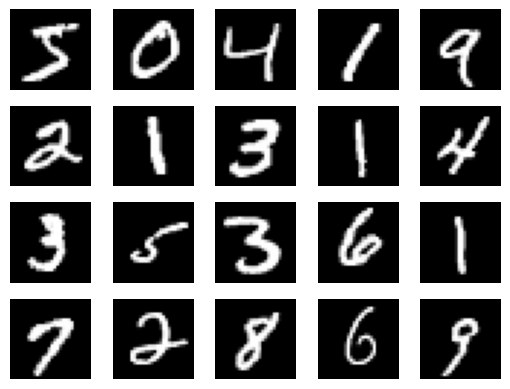

Linear Regression test_error = 0.7697
SVM one vs. rest test_error: 0.007499999999999951
Multiclass SVM test_error: 0.0816


NotImplementedError: 

In [84]:

#######################################################################
# 1. Introduction
#######################################################################

# Load MNIST data:
train_x, train_y, test_x, test_y = get_MNIST_data()
# Plot the first 20 images of the training set.
plot_images(train_x[0:20, :])

#######################################################################
# 2. Linear Regression with Closed Form Solution
#######################################################################

# TODO: first fill out functions in linear_regression.py, otherwise the functions below will not work


def run_linear_regression_on_MNIST(lambda_factor=0.01):
    """
    Trains linear regression, classifies test data, computes test error on test set

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_x_bias = np.hstack([np.ones([train_x.shape[0], 1]), train_x])
    test_x_bias = np.hstack([np.ones([test_x.shape[0], 1]), test_x])
    theta = closed_form(train_x_bias, train_y, lambda_factor)
    test_error = compute_test_error_linear(test_x_bias, test_y, theta)
    return test_error


# Don't run this until the relevant functions in linear_regression.py have been fully implemented.
print('Linear Regression test_error =', run_linear_regression_on_MNIST(lambda_factor=1))


#######################################################################
# 3. Support Vector Machine
#######################################################################

# TODO: first fill out functions in svm.py, or the functions below will not work

def run_svm_one_vs_rest_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('SVM one vs. rest test_error:', run_svm_one_vs_rest_on_MNIST())


def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('Multiclass SVM test_error:', run_multiclass_svm_on_MNIST())

#######################################################################
# 4. Multinomial (Softmax) Regression and Gradient Descent
#######################################################################

# TODO: first fill out functions in softmax.py, or run_softmax_on_MNIST will not work


def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    # TODO: add your code here for the "Using the Current Model" question in tab 6.
    #      and print the test_error_mod3
    return test_error


print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))

# TODO: Find the error rate for temp_parameter = [.5, 1.0, 2.0]
#      Remember to return the tempParameter to 1, and re-run run_softmax_on_MNIST

#######################################################################
# 6. Changing Labels
#######################################################################



def run_softmax_on_MNIST_mod3(temp_parameter=1):
    """
    Trains Softmax regression on digit (mod 3) classifications.

    See run_softmax_on_MNIST for more info.
    """
    # YOUR CODE HERE
    raise NotImplementedError


# TODO: Run run_softmax_on_MNIST_mod3(), report the error rate


#######################################################################
# 7. Classification Using Manually Crafted Features
#######################################################################

## Dimensionality reduction via PCA ##

# TODO: First fill out the PCA functions in features.py as the below code depends on them.


n_components = 18

###Correction note:  the following 4 lines have been modified since release.
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)

# train_pca (and test_pca) is a representation of our training (and test) data
# after projecting each example onto the first 18 principal components.


# TODO: Train your softmax regression model using (train_pca, train_y)
#       and evaluate its accuracy on (test_pca, test_y).


# TODO: Use the plot_PC function in features.py to produce scatterplot
#       of the first 100 MNIST images, as represented in the space spanned by the
#       first 2 principal components found above.
plot_PC(train_x[range(000, 100), ], pcs, train_y[range(000, 100)], feature_means)#feature_means added since release


# TODO: Use the reconstruct_PC function in features.py to show
#       the first and second MNIST images as reconstructed solely from
#       their 18-dimensional principal component representation.
#       Compare the reconstructed images with the originals.
firstimage_reconstructed = reconstruct_PC(train_pca[0, ], pcs, n_components, train_x, feature_means)#feature_means added since release
plot_images(firstimage_reconstructed)
plot_images(train_x[0, ])

secondimage_reconstructed = reconstruct_PC(train_pca[1, ], pcs, n_components, train_x, feature_means)#feature_means added since release
plot_images(secondimage_reconstructed)
plot_images(train_x[1, ])


## Cubic Kernel ##
# TODO: Find the 10-dimensional PCA representation of the training and test set


# TODO: First fill out cubicFeatures() function in features.py as the below code requires it.

train_cube = cubic_features(train_pca10)
test_cube = cubic_features(test_pca10)
# train_cube (and test_cube) is a representation of our training (and test) data
# after applying the cubic kernel feature mapping to the 10-dimensional PCA representations.


# TODO: Train your softmax regression model using (train_cube, train_y)
#       and evaluate its accuracy on (test_cube, test_y).
